## Conformance

Conformance refers to measuring how close the processes in a log match the processes allowed in a defined or "mined" process model. There are a number of metrices when measuring conformance. The primary metric is fitness, usually calculated with an algorithm such as token based replay.

By measuring fitness, we can identify traces that do not fit the expected or defined process model and measure changes in processes over time.

The conformance step can be seen in the PM$^2$ pathway below <sup>[1]</sup>.

[1]Van Eck, M. L., Lu, X., Leemans, S. J. & Van Der Aalst, W. M. (2015), Pm: a process mining project
methodology, in ‘International conference on advanced information systems engineering’, Springer, pp. 297–
313.

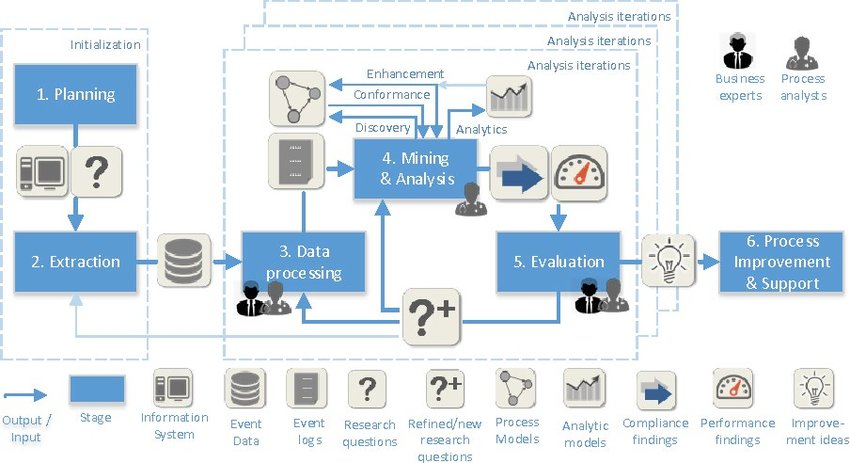

In [30]:
from IPython.display import Image, display
display(Image(filename='PM2_Process-Mining-Project-Methodology.png'))

In python we import open source packages with useful functions that will facillitate our programming

In [75]:
import pandas as pd
import re
import numpy as np
import pm4py
import seaborn as sns
from matplotlib import pyplot as plt
import math

from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.algo.conformance.tokenreplay import algorithm as token_based_replay
from pm4py.algo.filtering.log.start_activities import start_activities_filter
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

We download our pre-prepared event log

In [32]:
EL_df0=pd.read_csv('EventLogWAttsBusRules.csv')
EL_df0[['Timestamp']] = EL_df0[['Timestamp']].apply(pd.to_datetime, errors='coerce')
EL_df0.Patient_ID.nunique()

5435

We are going to perform many transformatins on our event log so it is smart to make a copy now so that we can revert any changes if required by rerunning the below cell.

In [33]:
EL_df1=EL_df0.copy()

make an event log object of the log

In [34]:
EL_df1 = pm4py.format_dataframe(EL_df1,case_id='Patient_ID', activity_key='Activity', timestamp_key='Timestamp')
log = pm4py.convert_to_event_log(EL_df1)

C:\Users\User\AppData\Local\Temp\ipykernel_14264\1520978026.py:1: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  EL_df1 = pm4py.format_dataframe(EL_df1,case_id='Patient_ID', activity_key='Activity', timestamp_key='Timestamp')
C:\Users\User\Anaconda3\envs\PM_env\Lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


In conformance checking we either have to use a predefned expected process model informed by experts to measure how well the real data conforms to the model. Or we have to get a model oursleves. One option is use the most common variant as the predefineed model.

Here we can see that the most common variant only accounts for 34.77% of the event log.

In [35]:
variants = pm4py.get_variants(log)

In [36]:
variantseq=['_'.join(i) for i in variants]
varperclog=[len(variants[i])/EL_df1.Patient_ID.nunique()*100 for i in variants]

In [37]:
VPL={'Variant':variantseq,'Percenatge of Log':varperclog}
VPL_df = pd.DataFrame(VPL)
VPL_df=VPL_df.sort_values('Percenatge of Log',axis=0, ascending=False)
VPL_df.head(30)

,Variant,Percenatge of Log
0,Incident_Time_Originated_Mobile_Arrive_scene_D...,34.774609
3,Incident_Time_Originated_Mobile_Arrive_scene_F...,21.085557
2,Incident_Time_Originated_Mobile_Arrive_scene_D...,12.180313
1,Incident_Time_Originated_Mobile_Arrive_scene_F...,10.726771
5,Incident_Time_Originated_Mobile_Arrive_scene_D...,9.273229
6,Incident_Time_Originated_Mobile_Arrive_scene_D...,4.710212
4,Incident_Time_Originated_Mobile_Arrive_scene_D...,3.477461
7,Incident_Time_Originated_Mobile_Arrive_scene_F...,2.042318
8,Incident_Time_Originated_Mobile_Arrive_scene_F...,1.232751
9,Incident_Time_Originated_Mobile_Arrive_scene_D...,0.496780


We can view that most common variant below

C:\Users\User\Anaconda3\envs\PM_env\Lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


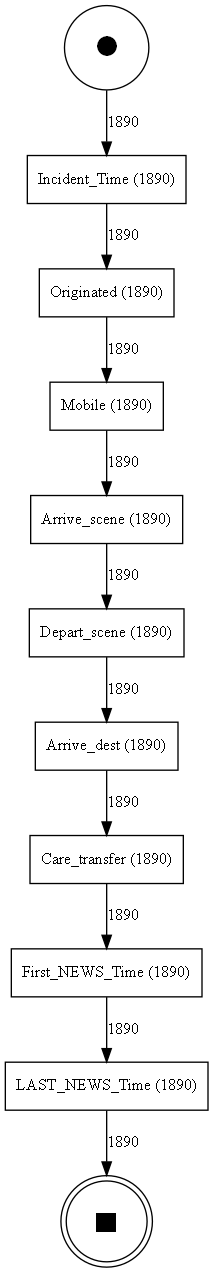

In [38]:
dfg, start_activities, end_activities = pm4py.discover_dfg(pm4py.filter_variants_top_k(log,1))
pm4py.view_dfg(dfg, start_activities, end_activities)

Other options include using one of the process mining algorithms to mine a process model from the eventlog.

There are many differnt rpocess mining algorithms each designed to capture behaviour the event log and show in an undertsnable model. Eaahc algorithm has its advanatges and weeknesses. 

Two commonly used algorithms include the heuristic miner and inudctive miner which are both suppported in pm4py.

In [69]:
set(EL_df1.Activity)

{'Arrive_dest',
 'Arrive_scene',
 'Care_transfer',
 'Depart_scene',
 'First_NEWS_Time',
 'Incident_Time',
 'LAST_NEWS_Time',
 'Mobile',
 'Originated'}

## Heuristic miner algorithm
Here we employ the heuristic miner to mine a process model from the event log and display it as a perti net.

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

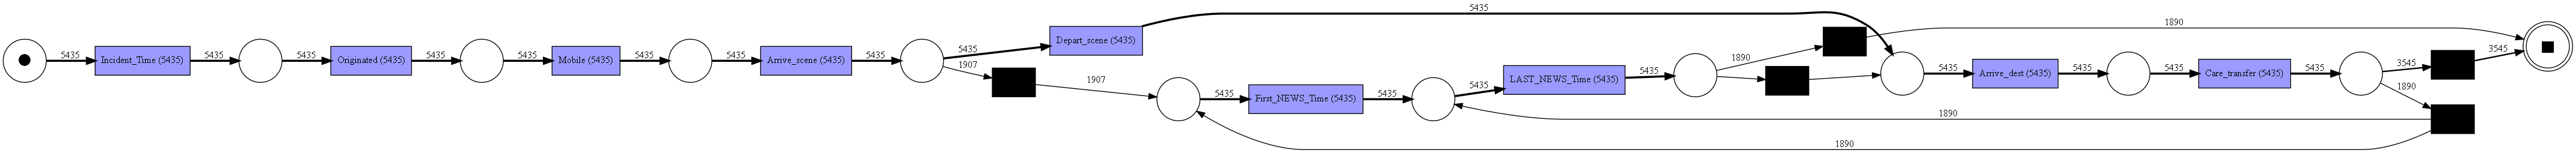

In [39]:
hnet, him, hfm = heuristics_miner.apply(log)
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(hnet, him, hfm, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)
pn_visualizer.view(gviz)

We can measure the fitness of the event log's traces to the petri net mined off of it.

In [82]:
parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: True, token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True}
replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(log, hnet, him, hfm,parameters=parameters_tbr)
fit = pm4py.fitness_token_based_replay(log, hnet, him, hfm)
print(fit)

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

{'perc_fit_traces': 0.0, 'average_trace_fitness': 0.9299874764916395, 'log_fitness': 0.9306163205518614, 'percentage_of_fitting_traces': 0.0}


## Inductive miner algorithm
Here we employ the inductive miner to mine a process model from the event log and display it as a perti net.

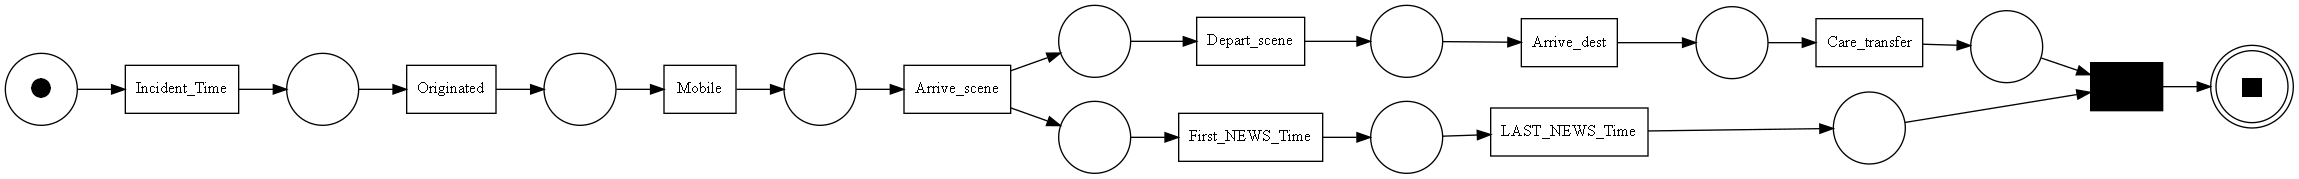

In [41]:
tree = inductive_miner.apply(log)
Inet,Iim,Ifm=pm4py.convert_to_petri_net(tree)
pm4py.view_petri_net(Inet,Iim,Ifm)

measure fitness of event log traces to the petri net mined off of it

In [42]:
parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: True, token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True}
Ireplayed_traces, Iplace_fitness, Itrans_fitness, Iunwanted_activities = token_based_replay.apply(log, Inet, Iim, Ifm,parameters=parameters_tbr)
Ifit = pm4py.fitness_token_based_replay(log, Inet, Iim, Ifm)
print(Ifit)

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

Here we see that the petri net produced by the inductively miner alllows all the traces to be played across it perfectly in token based replay. This petri net therefore has perfect fitness.

We can use other metrics to evaluate the process models including precision, generalisation and simplicity below. The inudicutive miner's petri net wins out in this case on all metrics. However in a different log with more vaiation the story might be different. It is common in literture to try multiple mining algorithms and evaualte multiple metrics before agreeing on a good process model. 

In [77]:
print('Precision of heuristic miner\'s petri net.',pm4py.precision_token_based_replay(log, hnet,him,hfm))
print('Precision of Inductive miner\'s petri net.',pm4py.precision_token_based_replay(log, Inet,Iim,Ifm))

print('Generalization of heuristic miner\'s petri net.',generalization_evaluator.apply(log, hnet,him,hfm))
print('Generalization of Inductive miner\'s petri net.',generalization_evaluator.apply(log, Inet,Iim,Ifm))

print('Simplicity of heuristic miner\'s petri net.',simplicity_evaluator.apply(hnet))
print('Simplicity of Inductive miner\'s petri net.',simplicity_evaluator.apply(Inet))

replaying log with TBR, completed variants ::   0%|          | 0/27 [00:00<?, ?it/s]

Precision of heuristic miner's petri net. 0.9354509503763235


replaying log with TBR, completed variants ::   0%|          | 0/27 [00:00<?, ?it/s]

Precision of Inductive miner's petri net. 1.0


replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

Generalization of heuristic miner's petri net. 0.9137300887939225


replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

Generalization of Inductive miner's petri net. 0.9864356113188103
Simplicity of heuristic miner's petri net. 0.8125
Simplicity of Inductive miner's petri net. 1.0


### Low Fitting Traces

If we had a defined process model, we can imagoine that identifying those trasces that do not fit the defined modell would be of interest.

Here we will assume that the heuristic miner's petri net is our defined process model (as we know that not all traces can be played across it perfectly), and we will idnetify teh traces with the least fitness to the petri net and display it in a DFG.

In [84]:
fitness=[]
for i in range(len(replayed_traces)):
    fitness.append([n for n in replayed_traces[i].values()][1])
np.mean(fitness)

0.9299874764916161

C:\Users\User\AppData\Local\Temp\ipykernel_14264\398357119.py:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  lowfitpatientdf1 = pm4py.format_dataframe(lowfitpatientdf,case_id='Patient_ID', activity_key='Activity', timestamp_key='Timestamp')
C:\Users\User\Anaconda3\envs\PM_env\Lib\site-packages\pm4py\utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
C:\Users\User\Anaconda3\envs\PM_env\Lib\site-packages\pm4py\utils.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

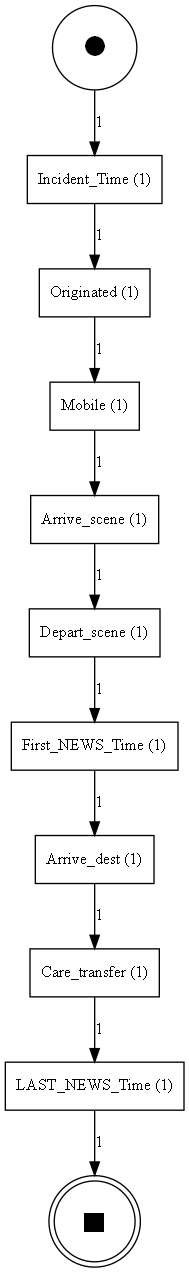

In [85]:
log[fitness.index(np.min(fitness))][0]['Patient_ID']
lowfitpatientdf=EL_df1[EL_df1.Patient_ID==log[668][0]['Patient_ID']]
lowfitpatientdf1 = pm4py.format_dataframe(lowfitpatientdf,case_id='Patient_ID', activity_key='Activity', timestamp_key='Timestamp')
lowfitpatientlog= pm4py.convert_to_event_log(lowfitpatientdf1)

dfg, start_activities, end_activities = pm4py.discover_dfg(lowfitpatientlog)

pm4py.view_dfg(dfg, start_activities, end_activities)

### Define a threhsold of fitness and Show Poor fitting traces
We can also difne a threshold fitness and display all tarces with a fitness equal to or below this value in a DFG

In [96]:
thresholdfitness=0.91

view dfg of poor fitting traces

C:\Users\User\AppData\Local\Temp\ipykernel_14264\4149290736.py:4: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  lowfitpatientsdf1 = pm4py.format_dataframe(lowfitpatientsdf,case_id='Patient_ID', activity_key='Activity', timestamp_key='Timestamp')
C:\Users\User\Anaconda3\envs\PM_env\Lib\site-packages\pm4py\utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
C:\Users\User\Anaconda3\envs\PM_env\Lib\site-packages\pm4py\utils.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

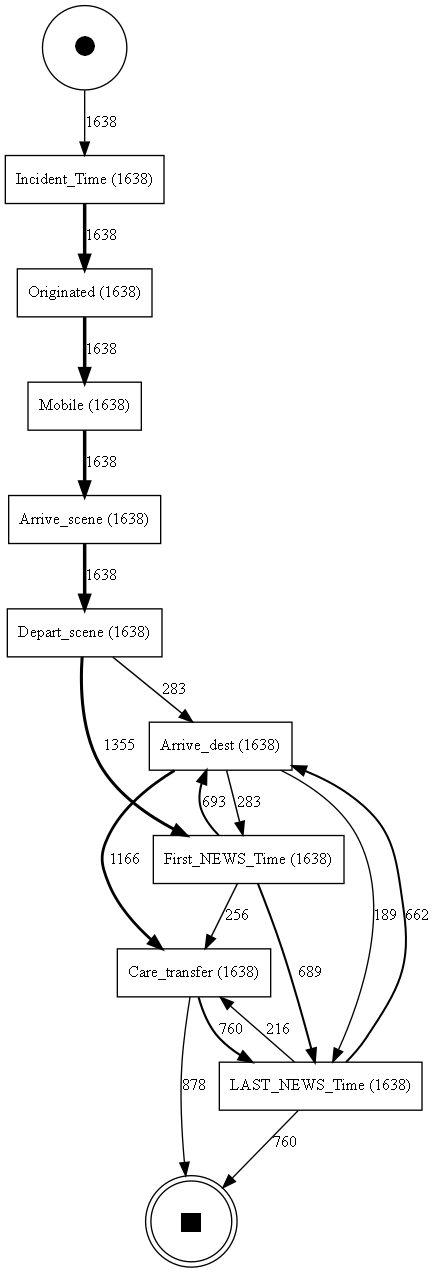

In [97]:
indpoorfit=[idx for idx,val in enumerate(fitness) if val <thresholdfitness]
pidpoorfit=[log[i][0]['Patient_ID'] for i in indpoorfit]
lowfitpatientsdf=EL_df1[EL_df1.Patient_ID.isin(pidpoorfit)]
lowfitpatientsdf1 = pm4py.format_dataframe(lowfitpatientsdf,case_id='Patient_ID', activity_key='Activity', timestamp_key='Timestamp')
lowfitpatientslog= pm4py.convert_to_event_log(lowfitpatientsdf1)
dfg, start_activities, end_activities = pm4py.discover_dfg(lowfitpatientslog)
pm4py.view_dfg(dfg, start_activities, end_activities)

## Conformance Checking on Specific Attributes (Outcomes, Highest Technician on Scene etc)

One avenue of investigation might be to see if the proceses for cases with specifc attributes differ greatly to the rest of the cases. An investigation like this might start by filtering the event log to the cases with the attribute of interest, defining a proces smodel for those cases and the measuring the fitness of the rest of the log to that proces model.


here is a short function to filter by attribute value

In [155]:
def filterattribute(EL_df1,AttributeName,chosenattributevalue):
    Epids=list(set(EL_df1[EL_df1[AttributeName]==chosenattributevalue].Patient_ID.values))
    Edf=EL_df1[EL_df1.Patient_ID.isin(Epids)]
    return pm4py.convert_to_event_log(Edf),Edf

Filter the sublog for job cylces that have the outcome "Treated & Transported"

In [156]:
Elog,Edf=filterattribute(EL_df1,"Outcome","Treated & Transported")

show dfg of filtered log

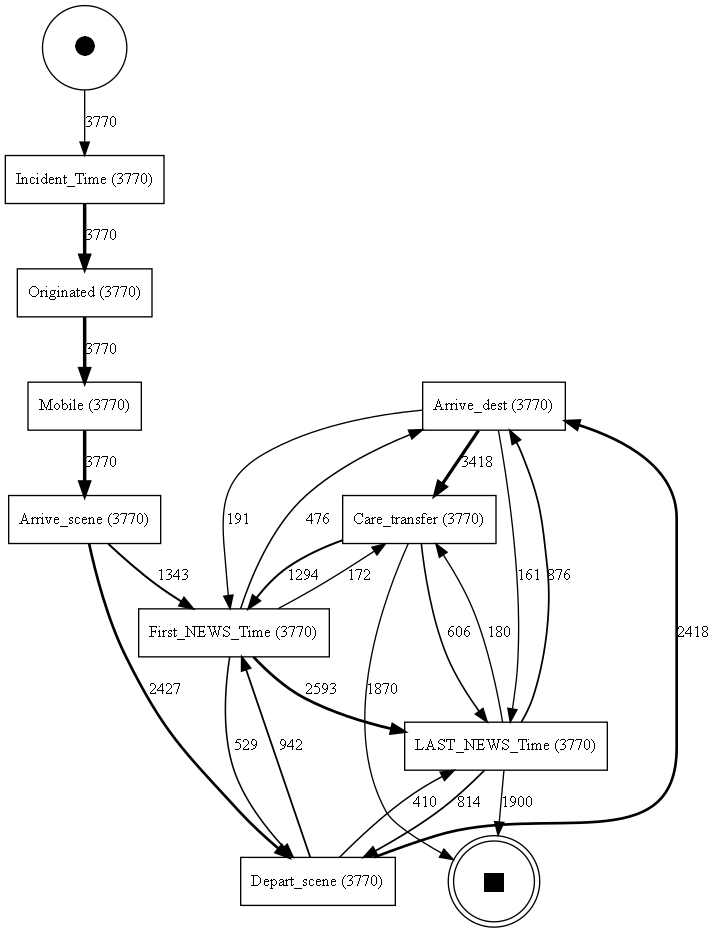

In [157]:
dfg, start_activities, end_activities = pm4py.discover_dfg(Elog)

pm4py.view_dfg(dfg, start_activities, end_activities)

make petri net from filtered log

In [158]:
ttnet, ttim, ttfm = heuristics_miner.apply(Elog)
parameters = {pn_visualizer.Variants.PERFORMANCE.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(ttnet, ttim, ttfm, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.PERFORMANCE, 
                           log=Elog)

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

measure fitness of unfiltered log on petri net

In [170]:
parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: True, token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True}
replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(log, ttnet, ttim, ttfm,parameters=parameters_tbr)
fitness=[]
for i in range(len(replayed_traces)):
    fitness.append([n for n in replayed_traces[i].values()][1])
    
np.mean(fitness)

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

0.9433623261130161

Identify poor fitting traces and show them in a DFG

C:\Users\User\AppData\Local\Temp\ipykernel_14264\1483881422.py:5: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  lowfitpatientsdf1 = pm4py.format_dataframe(lowfitpatientsdf,case_id='Patient_ID', activity_key='Activity', timestamp_key='Timestamp')
C:\Users\User\Anaconda3\envs\PM_env\Lib\site-packages\pm4py\utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
C:\Users\User\Anaconda3\envs\PM_env\Lib\site-packages\pm4py\utils.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

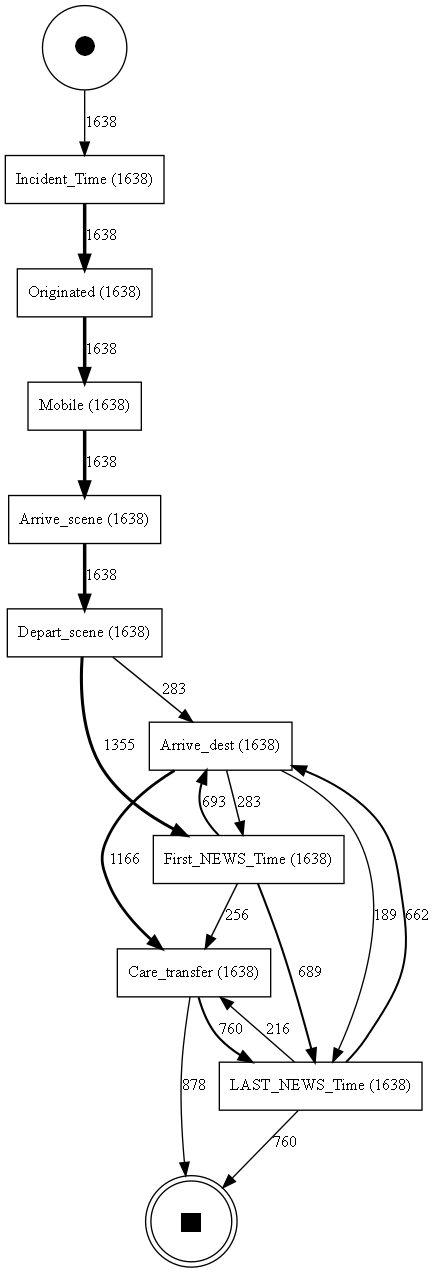

In [161]:
thresholdfitness=0.91
indpoorfit=[idx for idx,val in enumerate(fitness) if val <thresholdfitness]
pidpoorfit=[log[i][0]['Patient_ID'] for i in indpoorfit]
lowfitpatientsdf=EL_df1[EL_df1.Patient_ID.isin(pidpoorfit)]
lowfitpatientsdf1 = pm4py.format_dataframe(lowfitpatientsdf,case_id='Patient_ID', activity_key='Activity', timestamp_key='Timestamp')
lowfitpatientslog= pm4py.convert_to_event_log(lowfitpatientsdf1)

dfg, start_activities, end_activities = pm4py.discover_dfg(lowfitpatientslog)
pm4py.view_dfg(dfg, start_activities, end_activities)

## Filter on Highest Technician on Scene

In [163]:
Elog,Edf=filterattribute(EL_df1,"Highest Technician on Scene","Specialist Practicioner")

show dfg of filtered log

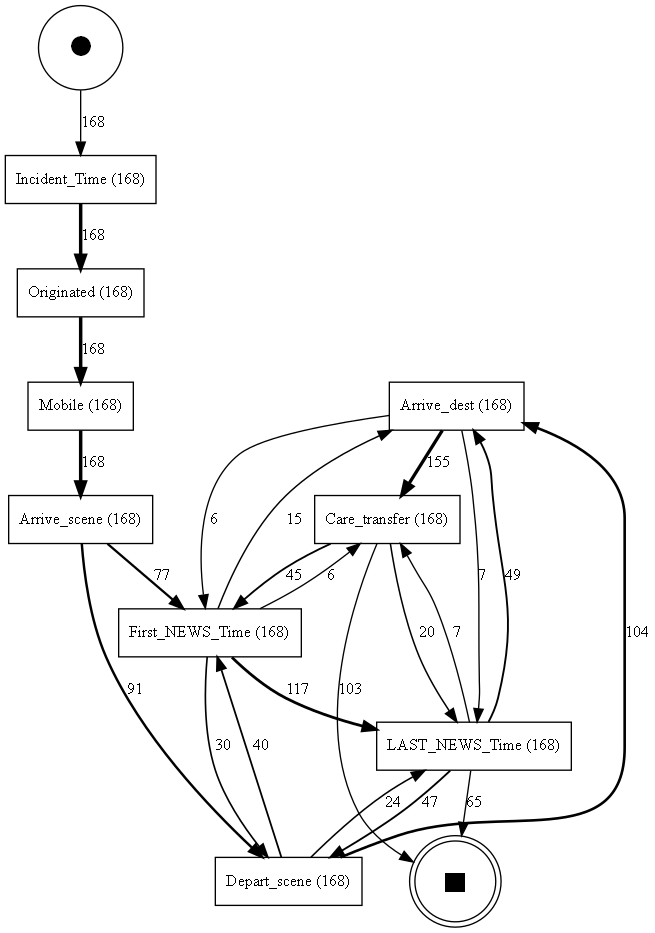

In [164]:
dfg, start_activities, end_activities = pm4py.discover_dfg(Elog)

pm4py.view_dfg(dfg, start_activities, end_activities)

make petri net from filtered log

In [165]:
ttnet, ttim, ttfm = heuristics_miner.apply(Elog)
parameters = {pn_visualizer.Variants.PERFORMANCE.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(ttnet, ttim, ttfm, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.PERFORMANCE, 
                           log=Elog)

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

measure fitness of unfiltered log on petri net

In [171]:
parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: True, token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True}
replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(log, ttnet, ttim, ttfm,parameters=parameters_tbr)
fitness=[]
for i in range(len(replayed_traces)):
    fitness.append([n for n in replayed_traces[i].values()][1])
    
np.mean(fitness)

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

0.9433623261130161

Identify poor fitting traces and show them in a DFG

C:\Users\User\AppData\Local\Temp\ipykernel_14264\1483881422.py:5: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  lowfitpatientsdf1 = pm4py.format_dataframe(lowfitpatientsdf,case_id='Patient_ID', activity_key='Activity', timestamp_key='Timestamp')
C:\Users\User\Anaconda3\envs\PM_env\Lib\site-packages\pm4py\utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
C:\Users\User\Anaconda3\envs\PM_env\Lib\site-packages\pm4py\utils.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

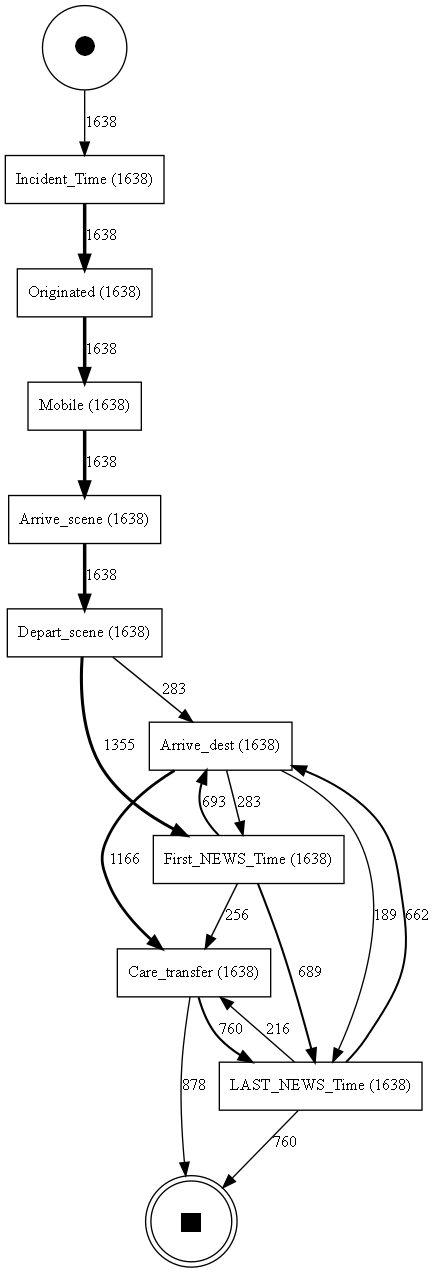

In [168]:
thresholdfitness=0.91
indpoorfit=[idx for idx,val in enumerate(fitness) if val <thresholdfitness]
pidpoorfit=[log[i][0]['Patient_ID'] for i in indpoorfit]
lowfitpatientsdf=EL_df1[EL_df1.Patient_ID.isin(pidpoorfit)]
lowfitpatientsdf1 = pm4py.format_dataframe(lowfitpatientsdf,case_id='Patient_ID', activity_key='Activity', timestamp_key='Timestamp')
lowfitpatientslog= pm4py.convert_to_event_log(lowfitpatientsdf1)

dfg, start_activities, end_activities = pm4py.discover_dfg(lowfitpatientslog)
pm4py.view_dfg(dfg, start_activities, end_activities)